In [2]:
import os, sys
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Merge, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam, Adamax
from keras.models import model_from_yaml
from keras.regularizers import l1, l2
from load_dataset import get_data, dataset
from utils import print_metadata, get_dgaze_frames_count, split_data, plot_gaze_points, save_model, load_model

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import copy
import cv2 

from numpy.random import seed
seed(33)

from tensorflow import set_random_seed
set_random_seed(26)

import random 
random.seed(10)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# from keras import backend as k
# import tensorflow as tf
# config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,
# allow_soft_placement=True, device_count = {'CPU': 1})
# sess = tf.Session(graph=tf.get_default_graph(),config=config)
# k.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load Dataset

In [3]:
data_path = '/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/'
model_save = '/ssd_scratch/cvit/isha/DGAZE2/DGAZE_weights/weights_lefteye'
drivers = os.listdir(data_path)
ndrivers = len(drivers)
sequences = 112

# Driver_data is dict contatining drivers user1, user 2.....etc. For each driver, we have 112 sequences and for   
# each sequence we have features like ['face_location', 'headpose_pupil', 'left_eye', 'gaze_point', 'right_eye'] 
driver_data = get_data(data_path, drivers, sequences)

# Print the total numer of frames in the dataset
get_dgaze_frames_count(driver_data, drivers)

# Prints the DGAZE Metadata including list of drivers, sequences and features 
#print_metadata(driver_data, ['drivers', 'sequences', 'features'])
print_metadata(driver_data, ['features'])

100%|██████████| 20/20 [00:05<00:00,  3.27it/s]


Total frames in DGAZE dataset is 227178
List of Features: ['left_eye', 'right_eye', 'face_location', 'gaze_point', 'headpose_pupil']



## Dataset Split

In [4]:
seq_range = np.arange(10, sequences+1)
nsequences = len(seq_range)
ndrivers = len(drivers)
random.shuffle(drivers)

dsplit = [int(0.8*ndrivers),int(0.1*ndrivers), int(0.1*ndrivers)]
gp_split = [int(0.6*nsequences),int(0.2*nsequences), int(0.2*nsequences)]
data_split = split_data(drivers, seq_range, dsplit, gp_split)

In [5]:
data_split



{'drivers_test': ['user17', 'user19'],
 'drivers_train': ['user24',
  'user23',
  'user22',
  'user12',
  'user18',
  'user2',
  'user8',
  'user13',
  'user5',
  'user3',
  'user10',
  'user21',
  'user16',
  'user11',
  'user14',
  'user15'],
 'drivers_val': ['user20', 'user7'],
 'sequence_test': array([ 84,  15, 109,  88,  66,  40, 104, 112,  56,  94,  48,  97,  32,
         68,  43,  96,  46,  63,  58,  55]),
 'sequence_train': array([ 49, 102,  28,  83,  26, 108,  57,  79,  11,  39, 105,  93,  91,
         95,  45,  90,  53,  23,  82,  81,  61, 110,  35,  75,  31,  60,
         42,  24,  77,  13,  47,  21,  54, 100,  85,  76,  71,  37, 103,
         22,  20,  73,  16,  17,  59,  64,  33, 107, 111,  19,  92,  44,
         14,  52,  86,  62,  29,  41,  69,  12,  25]),
 'sequence_val': array([ 36,  72,  38,  30,  74,  51,  18,  70,  65,  67,  80,  50,  89,
         99,  78, 101,  34,  98, 106,  10])}

## Train, Val and Test Dataset

In [6]:
# Training dataset
train = dataset(driver_data, data_split['drivers_train'], data_split['sequence_train'])

# Validation dataset
val = dataset(driver_data, data_split['drivers_val'], data_split['sequence_val'])

# Test dataset
test = dataset(driver_data, data_split['drivers_test'], data_split['sequence_test'])

100%|██████████| 2/2 [00:00<00:00, 19.28it/s]


In [7]:
print(train['left_eye'].shape, train['right_eye'].shape, train['gaze_point'].shape)

print(val['left_eye'].shape, val['right_eye'].shape, val['gaze_point'].shape)

print(test['left_eye'].shape, test['right_eye'].shape, test['gaze_point'].shape)

print("Total number of frames -->",train['gaze_point'].shape[0] + val['gaze_point'].shape[0]\
      + test['gaze_point'].shape[0])

(98306, 6, 10) (98306, 6, 10) (98306, 6)
(4779, 6, 10) (4779, 6, 10) (4779, 6)
(3761, 6, 10) (3761, 6, 10) (3761, 6)
Total number of frames --> 106846


In [8]:
# np.save('train.npy', train) 
# np.save('val.npy', val) 
# np.save('test.npy', test) 

In [9]:
# # Load
# train = np.load('train.npy',allow_pickle='TRUE').item()
# val = np.load('val.npy',allow_pickle='TRUE').item()
# test = np.load('test.npy',allow_pickle='TRUE').item()

## Turker Gaze

In [10]:
def get_data_turker_gaze(data):
    left_eye = data['left_eye']
    right_eye = data['right_eye']
    left_eye_vector = left_eye.reshape(-1, left_eye.shape[1] * left_eye.shape[2])
    right_eye_vector = right_eye.reshape(-1, right_eye.shape[1] * right_eye.shape[2])
    eye_vector = np.concatenate((left_eye_vector, right_eye_vector), axis =1)
    return eye_vector

In [11]:
train_data = get_data_turker_gaze(train)
val_data = get_data_turker_gaze(val)
test_data = get_data_turker_gaze(test)

trainY = train['gaze_point'][:,:2]
valY = val['gaze_point'][:,:2]
testY = test['gaze_point'][:,:2]

print("Training data", train_data.shape, trainY.shape)
print("Validation data", val_data.shape, valY.shape)
print("Testing data", test_data.shape, testY.shape)


Training data (98306, 120) (98306, 2)
Validation data (4779, 120) (4779, 2)
Testing data (3761, 120) (3761, 2)


In [16]:
clf = Ridge(alpha=0)
clf.fit(train_data, trainY)

train_pred = clf.predict(train_data)
val_pred = clf.predict(val_data)
test_pred = clf.predict(test_data)

print(mean_absolute_error(trainY, train_pred))
print(mean_absolute_error(valY, val_pred))
print(mean_absolute_error(testY, test_pred))



171.30021493636184
176.37883872892016
190.71715460032328


In [21]:
from copy import copy 

def plot_data(driver_path, driver_data, clf, train_data, trainY, driver, seq, n):
        
    video = driver_path + "/" + driver + "/original_road_view/sample_" + str(seq) + ".avi"
    driver_video = driver_path + "/" + driver + "/driver_view/sample_" + str(seq)+".avi"
        
    cap1 = cv2.VideoCapture(video) # road video
    cap2 = cv2.VideoCapture(driver_video) # driver video

    data = dataset(driver_data, [driver], np.arange(seq, seq+1))
   # data['face_features'] = scaler.transform(data['face_features'])
    
    if os.path.exists(video) and os.path.exists(driver_video):
        
        pred = clf.predict(get_data_turker_gaze(data)).astype(int)
        

        # After Calibration
        data_calibrate = dataset(driver_data, [driver], np.arange(1,10))

        train_data = np.concatenate((train_data, get_data_turker_gaze(data_calibrate)))
        trainY = np.concatenate((trainY, data_calibrate['gaze_point'][:,:2]))
        
        clf = Ridge(alpha=0.1)
        clf.fit(train_data, trainY)
#         model = load_model(model_save)
#         model.compile(loss='mae', optimizer=opt)
    
#         history = model.fit([data_calibrate['left_eye'], data_calibrate['face_features']],
#                                  data_calibrate['gaze_point'][:,:2], epochs=20, batch_size=batch_size, 
#                                  verbose=1, shuffle= True)

#         pred_calibrate = model.predict([data['left_eye'], data['face_features']]).astype(int)
        
        pred_calibrate= clf.predict(get_data_turker_gaze(data)).astype(int)

        print(mean_absolute_error(data['gaze_point'][:,:2], pred_calibrate))

        # Plot output
        for i in range(int(n/2)):
            ret, road_frame = cap1.read()
            ret1, driver_frame = cap2.read()

        frame1 = driver_frame
        frame2 = copy(road_frame)
        frame2 = cv2.circle(frame2, (data['gaze_point'][int(n/2),0], data['gaze_point'][int(n/2),1]), \
                            70, (0,255,0), -1)
        frame3 = copy(road_frame)
        frame3 = cv2.circle(frame3, (data['gaze_point'][int(n/2),0], data['gaze_point'][int(n/2),1]), \
                            70, (0,255,0), -1)
        frame3 = cv2.circle(frame3, (pred[int(n/2),0], pred[int(n/2),1]), \
                            70, (0, 0,255), -1)
        
        frame4 = copy(road_frame)
        for j in range(0, n):
            frame4 = cv2.circle(frame4,(data['gaze_point'][j,0], data['gaze_point'][j,1]), 70, (0,255,0), -1 )
            frame4 = cv2.circle(frame4,(pred[j,0], pred[j,1]), 70, (0,0,255), -1 )

        frame5 = copy(road_frame)
        for j in range(0, n):
            frame5 = cv2.circle(frame5,(data['gaze_point'][j,0], data['gaze_point'][j,1]), 70, (0,255,0), -1 )
            frame5 = cv2.circle(frame5,(pred_calibrate[j,0], pred_calibrate[j,1]), 70, (0,0,255), -1 )
 

        frame_array =  np.concatenate((frame1, frame2, frame3, frame4, frame5), axis =1)
        frame_array = cv2.resize(frame_array, (int(frame_array.shape[1]/4), int(frame_array.shape[0]/4)))

        plt.figure(figsize=(20,10))
        plt.axis('off')
        plt.imshow(frame_array)
        plt.show()

        return frame_array
    

  

100%|██████████| 1/1 [00:00<00:00, 76.18it/s]


44.43650793650794


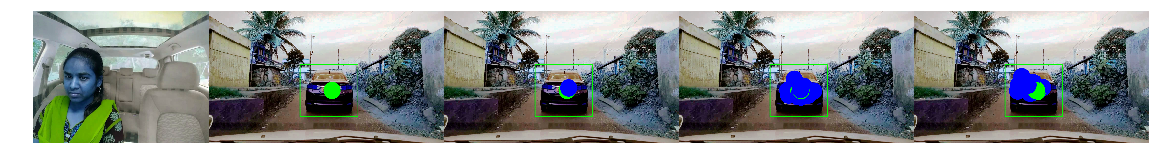

100%|██████████| 1/1 [00:00<00:00, 57.27it/s]


61.20982142857143


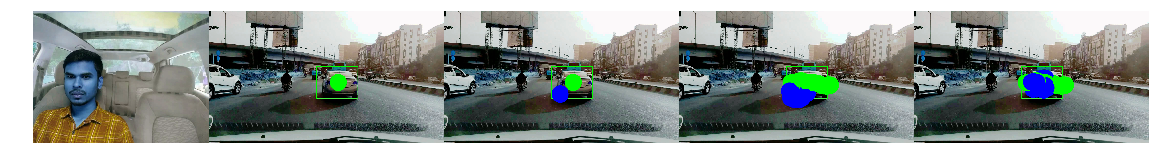

100%|██████████| 1/1 [00:00<00:00, 64.11it/s]


62.662790697674424


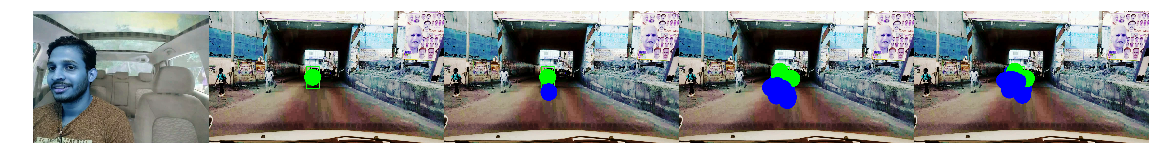

100%|██████████| 1/1 [00:00<00:00, 62.96it/s]


55.1123595505618


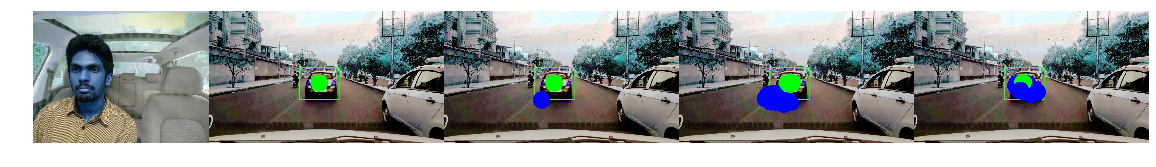

100%|██████████| 1/1 [00:00<00:00, 87.23it/s]


241.66315789473686


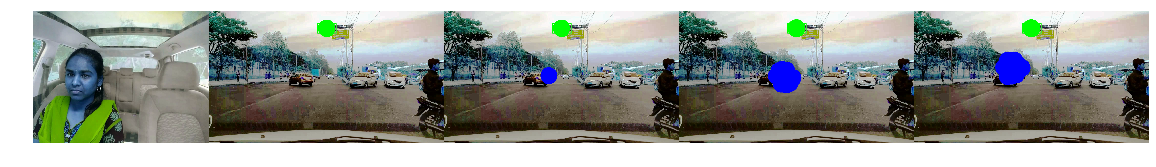

100%|██████████| 1/1 [00:00<00:00, 87.22it/s]


94.42105263157895


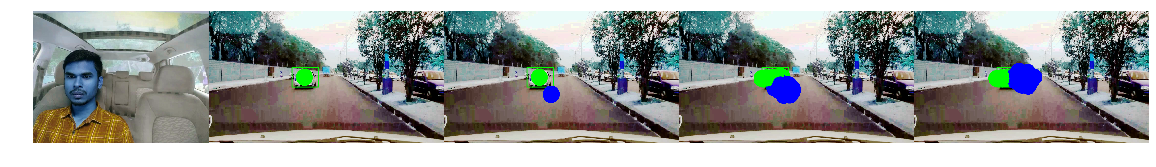

100%|██████████| 1/1 [00:00<00:00, 84.02it/s]


124.59558823529412


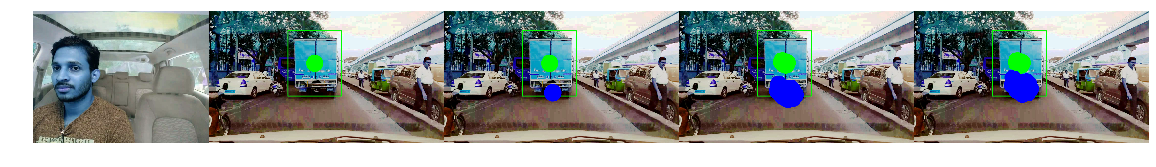

100%|██████████| 1/1 [00:00<00:00, 83.94it/s]


192.03750000000002


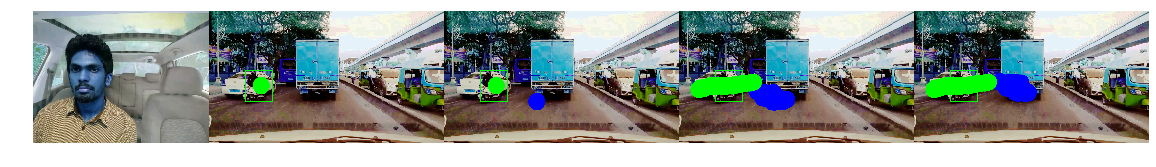

100%|██████████| 1/1 [00:00<00:00, 58.45it/s]


125.82993197278911


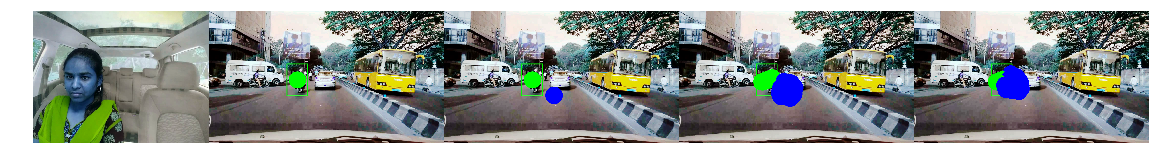

100%|██████████| 1/1 [00:00<00:00, 70.54it/s]


37.24031007751938


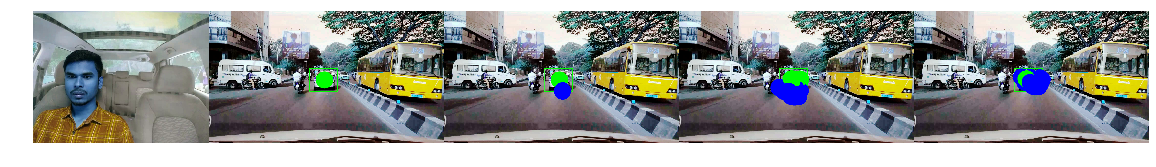

100%|██████████| 1/1 [00:00<00:00, 73.86it/s]


KeyboardInterrupt: 

In [22]:
users = data_split['drivers_test'] + data_split['drivers_val'] 
k =0
for j in range(10,100,5):
    k +=1
  #  image_name = 'qualitative_results'+str(k)+'.png'
    for i in range(len(users)):
        frame_array = plot_data(data_path, driver_data, clf, train_data, trainY, users[i], j+i, 50)

#         print(frame_array.shape)
#         if(i ==0):
#             frame_array2 = frame_array
#         else:
#             frame_array2 = np.concatenate((frame_array2, frame_array), axis =0)
#    # cv2.imwrite(image_name, frame_array2)